# Clustering - DVD Rental

<img src="https://drive.google.com/uc?id=1Q4nsZ1WsCtj6hP28RbVrOq-G9ASb-eis" width="100%" />


This is a public dataset which represents the business processes of a DVD rental store. The data contained in these tables is as follows -

|  **Table**               |  **Data Description**      |
|--------------------------|----------------------------|
|  **actor**                   |  actors data including first name and last name     |
|  **film**                    |  films data such as title, release year, length, rating, etc      |
|  film_actor              |  stores the relationships between films and actors |
|  **category**                |  stores film’s categories data |
|  film_category           |  stores the relationships between films and categories |
|  **store**                  |  store data including manager staff and address |
|  **inventory**               |  stores inventory data |
|  **rental**                  |  stores rental data |
|  **payment**                 |  stores customer's payments |
|  **staff**                   |  stores staff data |
|  **customer**                |  stores customer data |
|  **address**                 |  address data for staff and customers |
|  **city**                    |  stores city data |
|  **country**                 |  stores country data |


The data could be downloaded from this [link](https://drive.google.com/drive/folders/1YnMSCejTivA395KEUwn_CHM8A4IixkIY?usp=sharing).





# Settings

The company has started building their database and collectting data from their customers and business processes. They don't know how use the data to add values to their business, although they do know their business problems:

1. The company want to ***cluster*** their customers based on their preferences and behaviors. By distinguish different subsets of customers, the DvD rental company can run targeted marketing campaign to enhance customer loyalty and boost their revenue
2. In order to gain more attention from customers, they need to price their products fairly. The company hope that you could help them build a ***classification*** model, which allocates price tags to their movies.

# Part 1 - Clustering



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os

folder_path = '/content/drive/My Drive/dvd_rental/'

files = os.listdir(folder_path)

df = {}

for file in files:
    file_path = os.path.join(folder_path, file)
    # Read the CSV file and store it in a dictionary with the filename as the key
    df[file[:-4]] = pd.read_csv(file_path)  # file[:-4] to remove '.csv' from the filename



In [ ]:
# Get relevant dataframes
df_customer = df['customer']
df_rental = df['rental']
df_film = df['film']
df_film_category = df['film_category']
df_payment = df['payment']
df_address = df['address']
df_inventory = df['inventory']
df_city = df['city']
df_store = df['store']
df_category = df['category']

In [ ]:
# Join customer with address to get city
df_customer_address = pd.merge(df_customer, df_address, on='address_id')
df_customer_country = pd.merge(df_customer_address, df_city, on='city_id')
df_customerInfo = df_customer_country[['customer_id', 'country_id','store_id']]

# Join customer with rental
df_customer_rental = pd.merge(df_customerInfo, df_rental, on='customer_id')

# Join with payment
df_customer_rental_payment = pd.merge(df_customer_rental, df_payment, on='rental_id')

# Join with inventory
df_customer_rental_payment_inventory = pd.merge(df_customer_rental_payment, df_inventory, on='inventory_id')

# Create a table for film information
df_film.rename(columns={'last_update': 'last_update_film'}, inplace=True)

# Join film with film_category and category to get film_category
df_film_category.rename(columns={'last_update': 'last_update_category'}, inplace=True)
df_film_category_category = pd.merge(pd.merge(df_film_category, df_film, on='film_id'), df_category, on='category_id')
df_filmInfo = df_film_category_category[['film_id', 'length', 'rating','name', 'rental_duration', 'rental_rate', 'release_year']]
df_filmInfo = df_filmInfo.rename(columns = {'length': 'film_length', 'rating': 'film_rating', 'name': 'film_category', 'release_year': 'film_year'})

# Join customer details with film details
df_mergeAll = pd.merge(df_customer_rental_payment_inventory, df_filmInfo, on='film_id')

# Select and rename the required columns
df_final = df_mergeAll[['customer_id_x', 'rental_date', 'return_date', 'amount', 'film_length', 'film_category', 'film_rating', 'rental_duration', 'rental_rate', 'film_year']]
df_final = df_final.rename(columns = {'customer_id_x': 'customer_id', 'amount': 'payment_amount', 'rental_duration': 'allowed_rental_duration'})

# Calculate rental duration in days
df_final['rental_date'] = pd.to_datetime(df_final['rental_date'])
df_final['return_date'] = pd.to_datetime(df_final['return_date'])

df_final['rental_duration'] = (df_final['return_date'] - df_final['rental_date']).dt.days
df_final = df_final.drop(columns = ['rental_date', 'return_date'])

# Create new feature late = 1 if the rental is returned late
df_final['late'] = (df_final['allowed_rental_duration'] < df_final['rental_duration']).astype(int)
df_final = df_final.drop(columns = ['allowed_rental_duration'])


df_final.head(10)


customer_id  payment_amount  film_length film_category film_rating  \
0          524            1.99          123     Animation       NC-17   
1          147            0.99          123     Animation       NC-17   
2          350            0.99          123     Animation       NC-17   
3          531            5.99          123     Animation       NC-17   
4           71            0.99          123     Animation       NC-17   
5           75            3.99          123     Animation       NC-17   
6          436            0.99          123     Animation       NC-17   
7          131            4.99          123     Animation       NC-17   
8          161            0.99          123     Animation       NC-17   
9          167            0.99          123     Animation       NC-17   

   rental_rate  film_year  rental_duration  late  
0         0.99       2006              3.0     0  
1         0.99       2006              2.0     0  
2         0.99       2006              1.0     0  
3         0.99       2006              8.0     1  
4         0.99       2006              1.0     0  
5         0.99       2006              5.0     1  
6         0.99       2006              2.0     0  
7         0.99       2006              6.0     1  
8         0.99       2006              1.0     0  
9         0.99       2006              1.0     0

In [ ]:
# Create new dataframes to get specific information of a feature
df_film_rating_pref = df_final.groupby('customer_id')['film_rating'].describe()
df_avg_pmt = df_final.groupby('customer_id')['payment_amount'].describe()
df_avg_film_length = df_final.groupby('customer_id')['film_length'].describe()
df_avg_film_year = df_final.groupby('customer_id')['film_year'].describe()
no_of_film = df_final.groupby('customer_id')['customer_id'].count()


In [ ]:
# Group the entries by customer_id
df_group = df_final.groupby('customer_id').sum()
df_cluster = pd.merge(df_customerInfo, df_group, on='customer_id')

# Create new attributes
df_cluster['no_of_films'] = no_of_film
df_cluster['most_rating'] = df_film_rating_pref['top']
df_cluster['avg_payment'] = df_avg_pmt['mean']
df_cluster['avg_film_length'] = df_avg_film_length['mean']
df_cluster['avg_rental_duration'] = df_cluster['rental_duration']/df_cluster['no_of_films']


df_cluster = df_cluster.drop(columns = ['customer_id', 'film_category', 'film_length', 'payment_amount', 'rental_duration'])




In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Handle missing values
df_cluster = df_cluster.dropna()

# Normalization:
scaler = StandardScaler()
features_to_scale = ['country_id', 'avg_payment', 'avg_film_length', 'avg_rental_duration', 'film_year']
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Scale the selected features
df_cluster[features_to_scale] = scaler.fit_transform(df_cluster[features_to_scale])

# I chose the above features to scale because they are either ordinal or have very large values.
# Some numerical features that I didn't scale are features that have small numbers, categorical, or features that I think are more significant in clustering.

# Encode categorical data
df_cluster = pd.get_dummies(df_cluster, columns = ['most_rating'], dtype = int)
df_cluster = df_cluster.drop(columns = ['film_rating'])

df_cluster

<ipython-input-437-fbaa72be247d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster[features_to_scale] = scaler.fit_transform(df_cluster[features_to_scale])


country_id  store_id  rental_rate  film_year  late  no_of_films  \
1      0.453704         1        91.70   0.605263     9         30.0   
2      0.944444         1        77.74   0.500000    12         26.0   
3      0.351852         1        81.76   0.447368    16         24.0   
4      0.583333         2        63.78   0.394737     6         22.0   
5      0.842593         1        92.65   0.736842    14         35.0   
..          ...       ...          ...        ...   ...          ...   
594    0.203704         1        80.71   0.578947     9         23.0   
595    0.351852         1        61.78   0.394737     4         29.0   
596    0.675926         1        70.77   0.421053     7         22.0   
597    0.833333         1        59.78   0.394737    10         23.0   
598    0.203704         2        55.82   0.289474     8         22.0   

     avg_payment  avg_film_length  avg_rental_duration  most_rating_G  \
1       0.367536         0.645462             0.188929              0   
2       0.697059         0.539976             0.288736              0   
3       0.939688         0.582335             0.315179              0   
4       0.330193         0.560968             0.152110              1   
5       0.375919         0.575044             0.237143              0   
..           ...              ...                  ...            ...   
594     0.686461         0.321596             0.310559              0   
595     0.365513         0.702752             0.131773              0   
596     0.202159         0.385142             0.210065              0   
597     0.364985         0.412694             0.290994              0   
598     0.362201         0.766098             0.223701              1   

     most_rating_NC-17  most_rating_PG  most_rating_PG-13  most_rating_R  
1                    0               1                  0              0  
2                    0               0                  1              0  
3                    0               0                  0              1  
4                    0               0                  0              0  
5                    0               0                  0              1  
..                 ...             ...                ...            ...  
594                  0               0                  1              0  
595                  0               0                  1              0  
596                  0               0                  1              0  
597                  0               0                  0              1  
598                  0               0                  0              0  

[598 rows x 14 columns]

In [ ]:
# Check for null values
df_cluster[df_cluster.isna()].count()

country_id             0
store_id               0
rental_rate            0
film_year              0
rental_duration        0
late                   0
no_of_films            0
avg_payment            0
avg_film_length        0
avg_rental_duration    0
most_rating_G          0
most_rating_NC-17      0
most_rating_PG         0
most_rating_PG-13      0
most_rating_R          0
dtype: int64

In [ ]:
# Check for duplication
df_cluster[df_cluster.duplicated()].count()

country_id             0
store_id               0
rental_rate            0
film_year              0
rental_duration        0
late                   0
no_of_films            0
avg_payment            0
avg_film_length        0
avg_rental_duration    0
most_rating_G          0
most_rating_NC-17      0
most_rating_PG         0
most_rating_PG-13      0
most_rating_R          0
dtype: int64

## Train the model


In [ ]:
from sklearn.cluster import KMeans
#please you this as your K-Means clustering algorithm, you can use google/ chatgpt to learn how to use it + how to decide the optimal number of clusters and number of iterations

import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

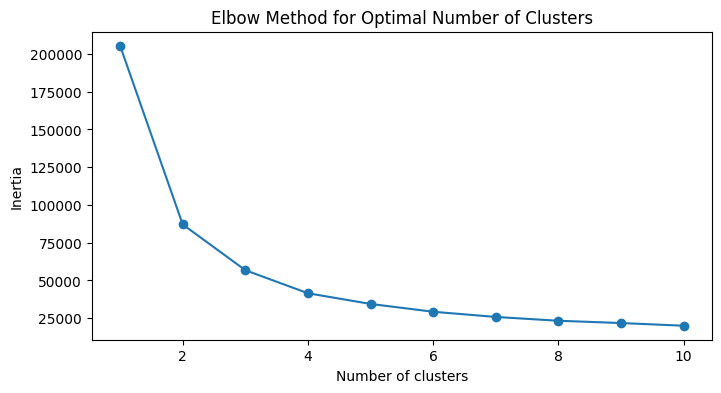

In [ ]:
#Determining the optimal number of clusters

inertia = []
for n in range(1, 11): #10 as an upper limit is considered to be a reasonable point to estimate the optimal number of clusters
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(df_cluster)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11, 1), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score

# Train the K-means model with the optimal number of clusters
optimal_clusters = 2  # The decrease in inertia slows down noticeably at k = 2
kmeans = KMeans(n_clusters=optimal_clusters, max_iter = 300, random_state=42)
kmeans.fit(df_cluster)

# Add the cluster labels to the original DataFrame
df_cluster['customer_segment'] = kmeans.labels_

# Evaluate the model
score = silhouette_score(df_cluster, kmeans.labels_)
print("The silhouette_score is ", score)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette_score is  0.48593370701982175


In [ ]:
# Evaluating the model with different max_iter using silhouette_score

kmeans1 = KMeans(n_clusters=optimal_clusters, max_iter = 100, random_state=42)
kmeans1.fit(df_cluster)
kmeans2 = KMeans(n_clusters=optimal_clusters, max_iter = 500, random_state=42)
kmeans2.fit(df_cluster)
kmeans3 = KMeans(n_clusters=optimal_clusters, max_iter = 1000, random_state=42)
kmeans3.fit(df_cluster)

score1 = silhouette_score(df_cluster, kmeans1.labels_)
score2 = silhouette_score(df_cluster, kmeans2.labels_)
score3 = silhouette_score(df_cluster, kmeans3.labels_)

print("The silhouette_score for max_iter = 100 is ", score1)
print("The silhouette_score for max_iter = 500 is ", score2)
print("The silhouette_score for max_iter = 1000 is ", score3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The silhouette_score for max_iter = 100 is  0.48593370701982175
The silhouette_score for max_iter = 500 is  0.48593370701982175
The silhouette_score for max_iter = 1000 is  0.48593370701982175


## Visualize clusters

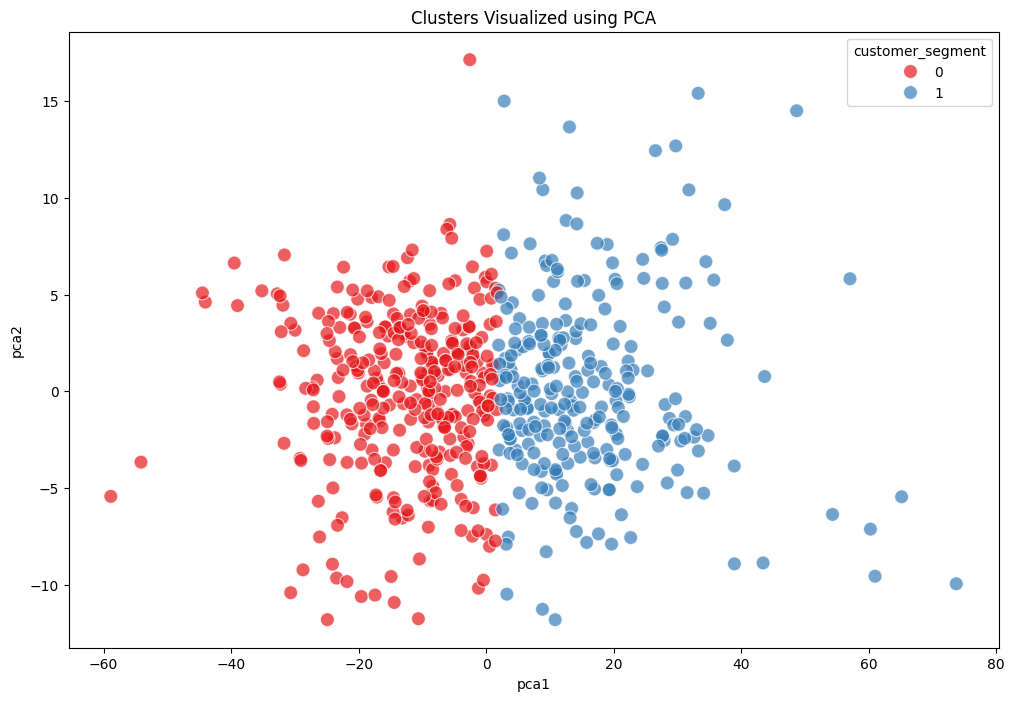

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_pca = pca.fit_transform(df_cluster)
df_cluster['pca1'] = features_pca[:, 0]
df_cluster['pca2'] = features_pca[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_cluster, x='pca1', y='pca2', hue='customer_segment', palette='Set1', s=100, alpha=0.7)
plt.title('Clusters Visualized using PCA')
plt.show()

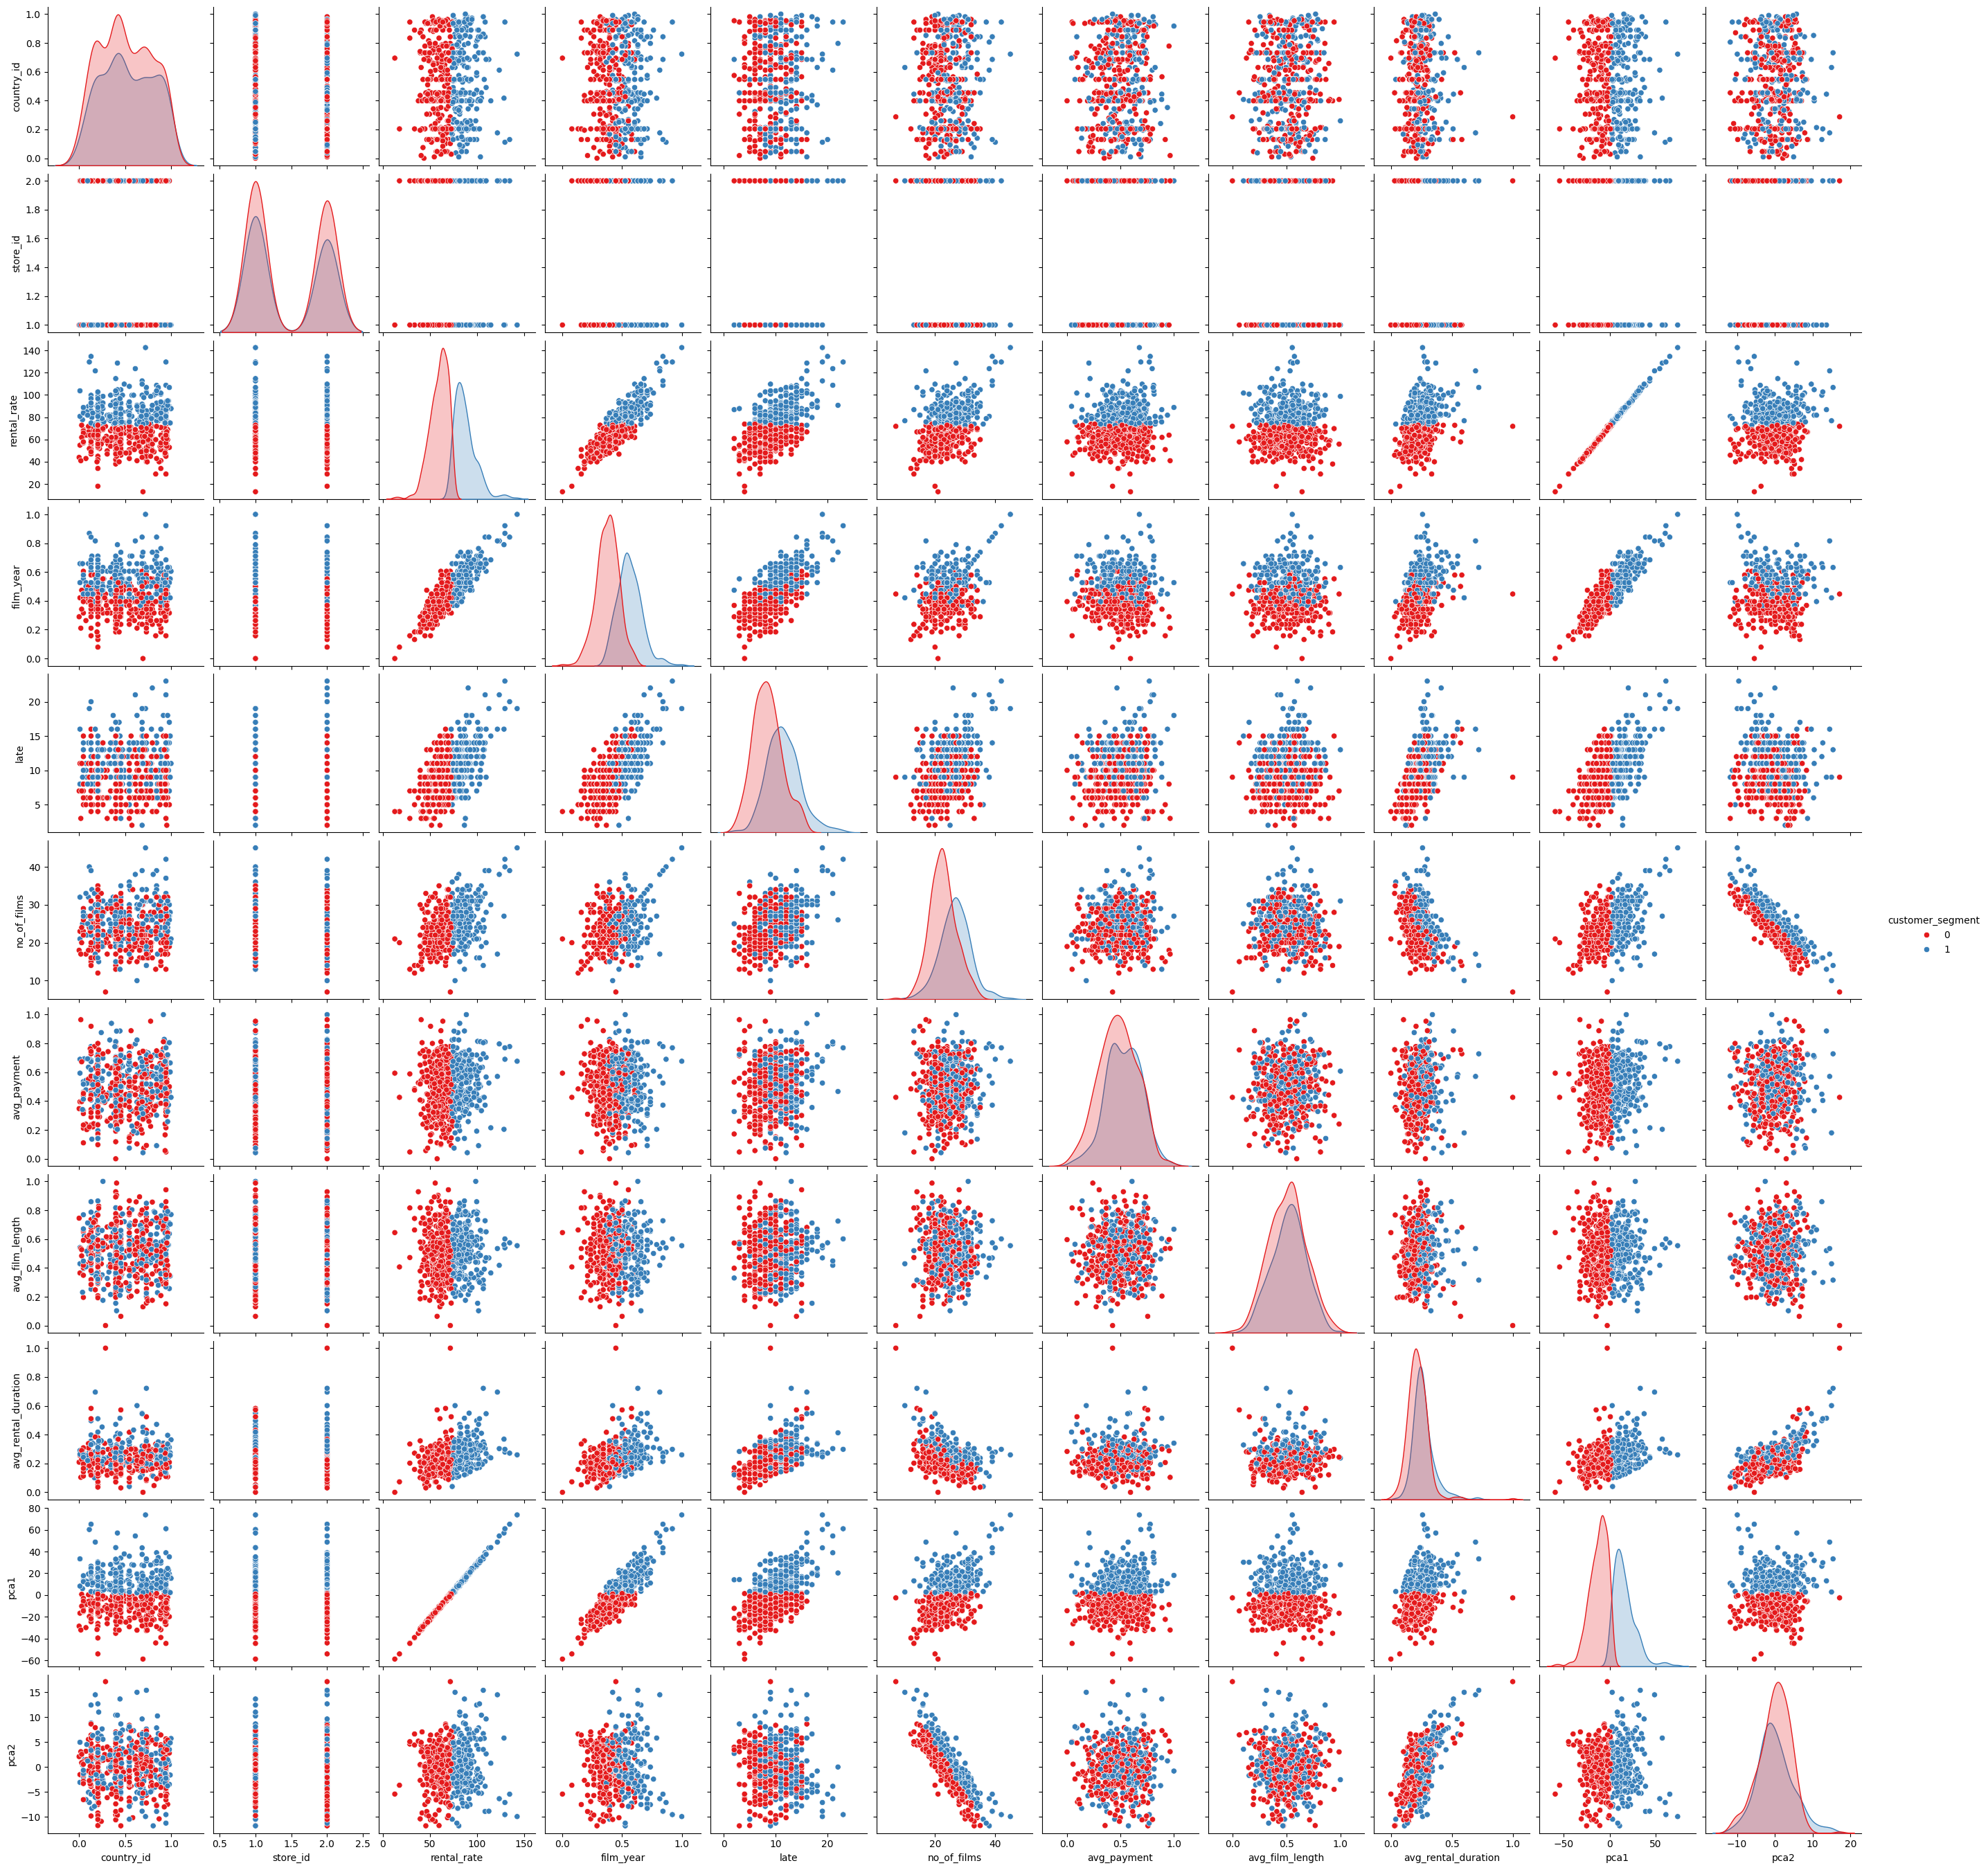

In [ ]:
# Create pairplot
sns.pairplot(df_cluster.drop(columns=['most_rating_G','most_rating_NC-17', 'most_rating_PG', 'most_rating_PG-13', 'most_rating_R']), hue='customer_segment', palette='Set1', diag_kind='kde')

# Show the plot
plt.show()

**Cluster visualization choice**

I would prefer the binary relationship plots over PCA since the PCA graph is not very interpretable. We do not know the linear combinations of features that the PCA uses, so we don't know how the model divided data into clusters. Using the pair plots, it is easier to see the relationships between features.

Generally speaking, the clusters seem to be pretty poorly separated. They overlap and are not clearly clustered. The summary of some features showed that the clusters are not really different from one another, with similar mean and percentiles. Therefore, it might not say a lot about the data and cannot segment the customers effectively

KDE: The most notable graphs are kernel density estimation ones, as there are most visible differences among features.
* Rental rate is probably the feature with the most clearly separated data in the kernel graphs since the first PCA uses its KDE. To be more specific, the customers are likely grouped by how much they spend on renting the films in total.
* Film year, number of films, and how many times customers return the films late are less clearly separated in terms of clusters, but they are still better than the rest. They are slightly skewed differently, indicating differences in distributions of the features' values.
* It can be seen that group 0 (red) spend less and watch less film in general. However, the mean of the rental rates between 2 groups seem farther away than the number of films. Therefore, we can also infer that group 1 (blue) tend to spend more on average for each film.

Scatter plots:
* Linear relationships: Aside from the obvious relationships between (total) film year, rental rate, and number of films, , there is no clear linear relationships. There is, however, a slight positive correlation for 'late' and the mentioned 3 features. One can infer that the proportion that the customers return the film late don;t vary much. The more they borrow, the more times they return the films late. The averages are more significant to look at when examining linear relationships, but they show no clear correlation.

Overall, we can see that there is not much differences in terms of geographical information (country, store) for the clusters. The customre are segmented based on how much they spend and consume the films. Segment 0 spend and watch less, while segment 1 spend and watch more.The segments don't have a lot of meanings and may not be significant since a lot of the features have values that don't differ much throughout the dataset.


# Part 2 - Classification

In [ ]:
# Create a dictionary with the data
data = {
    'class': ['Cheap', 'Moderate', 'Expensive'],
    'rental_rate': [0.99, 2.99, 4.99]
}

# Create a DataFrame from the dictionary
df_classes = pd.DataFrame(data)

# Display the DataFrame
print(df_classes)

       class  rental_rate
0      Cheap         0.99
1   Moderate         2.99
2  Expensive         4.99


In [ ]:
# Add inventory count, relevant features already available in an existing dataframe
inventory_count = df_inventory.groupby('film_id')['inventory_id'].count().reset_index(name='inventory_count')

df_class = df_mergeAll[['film_id', 'film_length', 'film_rating', 'film_category', 'amount', 'rental_duration', 'rental_rate']]
df_class = df_class.rename(columns = {'customer_id_x': 'customer_id', 'amount': 'payment_amount', 'rental_duration': 'allowed_rental_duration'})

df_class = pd.merge(df_class, inventory_count, on='film_id')

df_class


film_id  film_length film_rating film_category  payment_amount  \
0          461          123       NC-17     Animation            1.99   
1          461          123       NC-17     Animation            0.99   
2          461          123       NC-17     Animation            0.99   
3          461          123       NC-17     Animation            5.99   
4          461          123       NC-17     Animation            0.99   
...        ...          ...         ...           ...             ...   
14591      781          127           R         Games            4.99   
14592      781          127           R         Games            4.99   
14593      781          127           R         Games            8.99   
14594      781          127           R         Games            4.99   
14595      781          127           R         Games            6.99   

       allowed_rental_duration  rental_rate  inventory_count  
0                            3         0.99                6  
1                            3         0.99                6  
2                            3         0.99                6  
3                            3         0.99                6  
4                            3         0.99                6  
...                        ...          ...              ...  
14591                        4         4.99                2  
14592                        4         4.99                2  
14593                        4         4.99                2  
14594                        4         4.99                2  
14595                        4         4.99                2  

[14596 rows x 8 columns]

In [ ]:
# Count the number of times a film is rented
df_film_count = df_class.groupby('film_id')['film_id'].count()
df_film_count
# Handle missing values
df_class = df_class.dropna()

# Normalization: There is no data that require scaling since most of the numbers are ID or encoded data. Also, the model that I use (rtf) is not too sensitive to scaled data.

# Remove dupicates
df_class = df_class.drop_duplicates(subset = 'film_id')

# Add number of times that the film is rented
df_film_count = df_film_count.to_frame().rename(columns = {'film_id': 'rent_count'})
df_class = pd.merge(df_class, df_film_count, on = 'film_id')

# Add release year, language, replacement cost
df_moreFilmInfo = df_film[['film_id', 'release_year', 'language_id', 'replacement_cost']]
df_class = pd.merge(df_class, df_moreFilmInfo, on = 'film_id')

# Add class using the classes table
df_class = pd.merge(df_class, df_classes, on = 'rental_rate', how = 'left')

# Drop film ID and rental rate
df_class = df_class.drop(columns = ['film_id', 'rental_rate'])

# Encode categorical data:
df_class = pd.get_dummies(df_class, columns = ['film_rating', 'film_category'], dtype = int)
df_class['class'] = pd.factorize(df_class['class'])[0]

df_class

film_length  payment_amount  allowed_rental_duration  inventory_count  \
0            123            1.99                        3                6   
1            109            4.99                        4                4   
2            107            2.99                        7                4   
3             85            5.99                        4                6   
4            169            4.99                        4                3   
..           ...             ...                      ...              ...   
953           71            3.99                        3                2   
954           63            7.99                        4                2   
955          184            2.99                        4                2   
956           58            0.99                        7                2   
957          127            4.99                        4                2   

     rent_count  release_year  language_id  replacement_cost  class  \
0            18          2006            1             14.99      0   
1            15          2006            1             11.99      1   
2            12          2006            1             11.99      2   
3            22          2006            1             14.99      2   
4            10          2006            1             21.99      2   
..          ...           ...          ...               ...    ...   
953           5          2006            1             18.99      2   
954           5          2006            1             13.99      2   
955           5          2006            1             27.99      2   
956           6          2006            1             15.99      0   
957           5          2006            1             15.99      1   

     film_rating_G  ...  film_category_Drama  film_category_Family  \
0                0  ...                    0                     0   
1                0  ...                    0                     0   
2                0  ...                    0                     0   
3                0  ...                    0                     0   
4                0  ...                    0                     0   
..             ...  ...                  ...                   ...   
953              0  ...                    0                     0   
954              1  ...                    1                     0   
955              0  ...                    0                     0   
956              0  ...                    0                     0   
957              0  ...                    0                     0   

     film_category_Foreign  film_category_Games  film_category_Horror  \
0                        0                    0                     0   
1                        1                    0                     0   
2                        0                    0                     0   
3                        0                    0                     0   
4                        0                    0                     0   
..                     ...                  ...                   ...   
953                      0                    0                     0   
954                      0                    0                     0   
955                      0                    0                     0   
956                      0                    0                     0   
957                      0                    1                     0   

     film_category_Music  film_category_New  film_category_Sci-Fi  \
0                      0                  0                     0   
1                      0                  0                     0   
2                      0                  0                     0   
3                      0                  0                     0   
4                      0                  1                     0   
..                   ...                ...                   ...   
953           

In [ ]:
# Check for duplication
df_class[df_class.duplicated()].count()

film_length                  0
payment_amount               0
allowed_rental_duration      0
inventory_count              0
rent_count                   0
release_year                 0
language_id                  0
replacement_cost             0
class                        0
film_rating_G                0
film_rating_NC-17            0
film_rating_PG               0
film_rating_PG-13            0
film_rating_R                0
film_category_Action         0
film_category_Animation      0
film_category_Children       0
film_category_Classics       0
film_category_Comedy         0
film_category_Documentary    0
film_category_Drama          0
film_category_Family         0
film_category_Foreign        0
film_category_Games          0
film_category_Horror         0
film_category_Music          0
film_category_New            0
film_category_Sci-Fi         0
film_category_Sports         0
film_category_Travel         0
dtype: int64

In [ ]:
# Check for null values
df_class[df_class.isna()].count()

film_length                  0
payment_amount               0
allowed_rental_duration      0
inventory_count              0
rent_count                   0
release_year                 0
language_id                  0
replacement_cost             0
class                        0
film_rating_G                0
film_rating_NC-17            0
film_rating_PG               0
film_rating_PG-13            0
film_rating_R                0
film_category_Action         0
film_category_Animation      0
film_category_Children       0
film_category_Classics       0
film_category_Comedy         0
film_category_Documentary    0
film_category_Drama          0
film_category_Family         0
film_category_Foreign        0
film_category_Games          0
film_category_Horror         0
film_category_Music          0
film_category_New            0
film_category_Sci-Fi         0
film_category_Sports         0
film_category_Travel         0
dtype: int64

## Train the model

### Train your model here

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Identifying the feature columns, which are all columns aside from class
features = ['film_length', 'payment_amount', 'allowed_rental_duration',
       'inventory_count', 'rent_count', 'release_year', 'language_id',
       'replacement_cost', 'film_rating_G', 'film_rating_NC-17',
       'film_rating_PG', 'film_rating_PG-13', 'film_rating_R',
       'film_category_Action', 'film_category_Animation',
       'film_category_Children', 'film_category_Classics',
       'film_category_Comedy', 'film_category_Documentary',
       'film_category_Drama', 'film_category_Family', 'film_category_Foreign',
       'film_category_Games', 'film_category_Horror', 'film_category_Music',
       'film_category_New', 'film_category_Sci-Fi', 'film_category_Sports',
       'film_category_Travel']
X = df_class[features]
y = df_class['class']

# Randomize the datasets into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Use the Random Forest Classifier for our train sets
rf = RandomForestClassifier(max_depth=3, random_state=0)
rf.fit(X_train, y_train)
# Make prediction set y_pred for the set X_test
y_pred = rf.predict(X_test)

# Comparing y_test with y_pred to find the accuracy score
metrics.accuracy_score(y_test, y_pred)



0.7569444444444444

### Cross validation

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Initiate the stratified k-fold method, splitting the set to 5 smaller sets
sk_folds = StratifiedKFold(n_splits = 5)
sk_folds1 = StratifiedKFold(n_splits = 10)

# Perform cross validation on the sets
scores = cross_val_score(rf, X, y, cv = sk_folds)
scores1 = cross_val_score(rf, X, y, cv = sk_folds1)

# Print out the results - accuracy score for each subset and mean accuracy (or cross validation score)
print("Cross Validation Scores for 5 Folds: ", scores)
print("Average CV Score for 5 Fold: ", scores.mean())
print("\nCross Validation Scores for 10 Folds: ", scores1)
print("Average CV Score for 10 Folds: ", scores1.mean())

Cross Validation Scores for 5 Folds:  [0.75       0.69270833 0.71875    0.67015707 0.72774869]
Average CV Score for 5 Fold:  0.7118728184991274

Cross Validation Scores for 10 Folds:  [0.6875     0.75       0.69791667 0.80208333 0.72916667 0.71875
 0.69791667 0.65625    0.67368421 0.75789474]
Average CV Score for 10 Folds:  0.7171162280701754


## Analyse model predictions

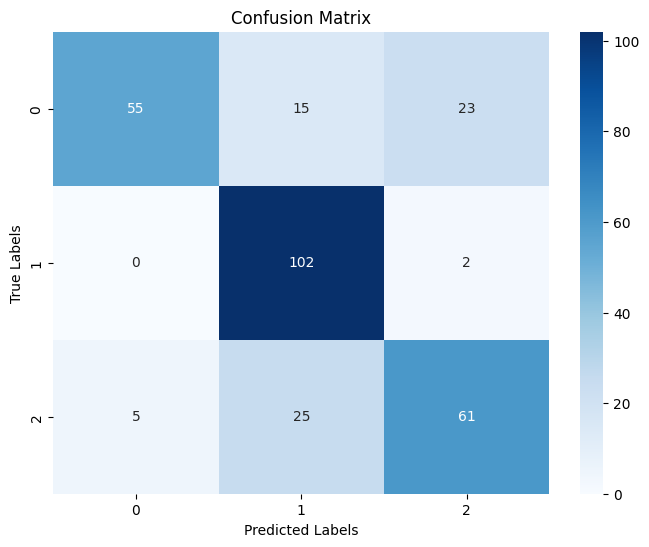

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=df_class['class'].unique(), yticklabels=df_class['class'].unique())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

[Text(0.5, 0.875, 'film_rating_R <= 0.5\ngini = 0.664\nsamples = 422\nvalue = [253, 205, 212]\nclass = Cheap'),
 Text(0.25, 0.625, 'inventory_count <= 2.5\ngini = 0.661\nsamples = 338\nvalue = [206, 153, 168]\nclass = Cheap'),
 Text(0.125, 0.375, 'film_category_Children <= 0.5\ngini = 0.647\nsamples = 46\nvalue = [17, 21, 30]\nclass = Expensive'),
 Text(0.0625, 0.125, 'gini = 0.655\nsamples = 44\nvalue = [17, 21, 27]\nclass = Expensive'),
 Text(0.1875, 0.125, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 3]\nclass = Expensive'),
 Text(0.375, 0.375, 'film_category_Travel <= 0.5\ngini = 0.657\nsamples = 292\nvalue = [189, 132, 138]\nclass = Cheap'),
 Text(0.3125, 0.125, 'gini = 0.654\nsamples = 276\nvalue = [184, 123, 125]\nclass = Cheap'),
 Text(0.4375, 0.125, 'gini = 0.623\nsamples = 16\nvalue = [5, 9, 13]\nclass = Expensive'),
 Text(0.75, 0.625, 'inventory_count <= 4.5\ngini = 0.665\nsamples = 84\nvalue = [47, 52, 44]\nclass = Moderate'),
 Text(0.625, 0.375, 'film_category_Games <= 0.5\ngi

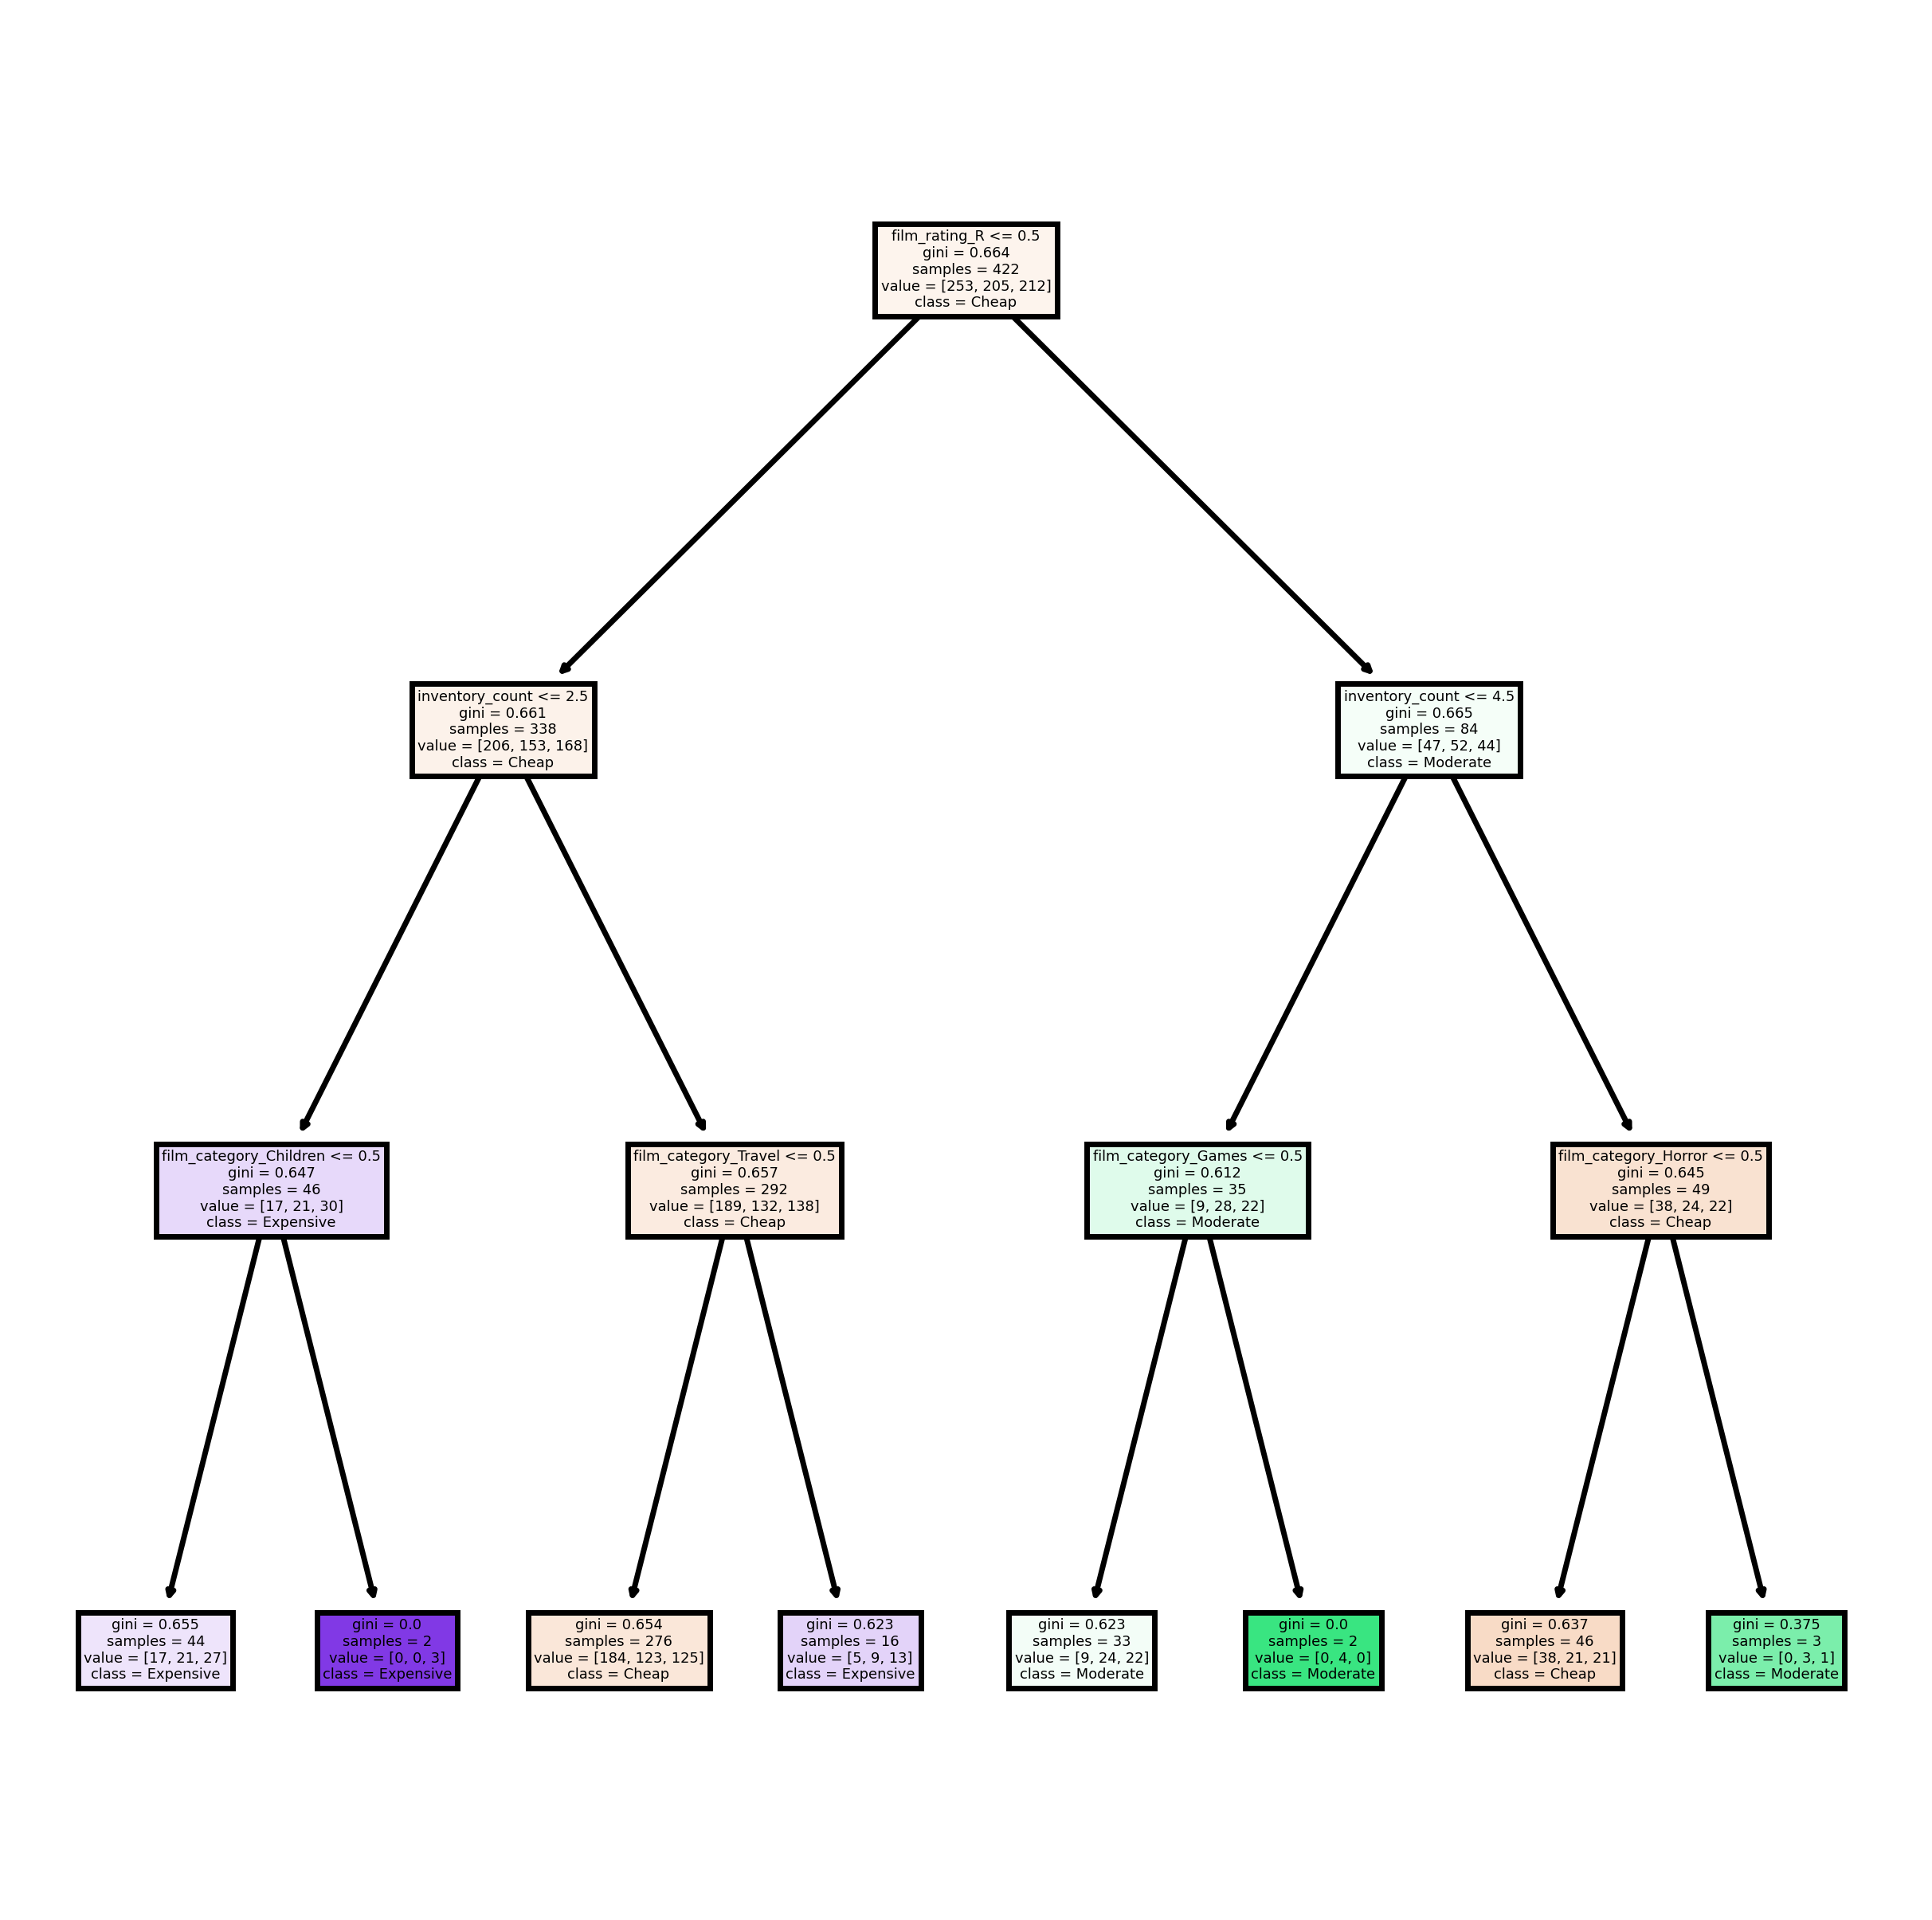

In [ ]:
from sklearn.tree import plot_tree
import sklearn.tree

# Plot the tree
tree = rf.estimators_[0]

fn= features
cn= ['Cheap', 'Moderate', 'Expensive']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,6), dpi=500)
sklearn.tree.plot_tree(rf.estimators_[0], feature_names = fn, class_names=cn, filled = True)

From the confusion matrix, we can see that class 1 has the most correct predictions, but at the same time, most wrong predictions are mistaken as class 1. The model seems to be quite biased when labelling the entries, and label more as class 1 than the other 2 classes. Looking at the plot, it is hard to tell where the bias came from. However, one can guess that the model chose features with more levels like categories and rating to reduce the gini impurity, which might make more relevant features overlooked. It is also common for larger classes to get more entries assigned to it to reduce gini.

In [ ]:
# Accruracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision}')

# Recall
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall: {recall}')

# F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score: {f1}')

Accuracy: 0.7395833333333334
Precision: 0.7541762578306808
Recall: 0.7395833333333334
F1 Score: 0.7372534077381302


* Accuracy: The overall correctness of the model is not that useful since the class labels are not uniformly distributed (the numbers of films in class 1 is visibly higher than the other 2).
* Precision: It focuses the accuracy of positive predictions. The positive predictions are not too precise, meaning they still vary quite a bit.
* Recall: The model has limited ability to find relevant cases (positive samples).
* F1 Score: The mean of precision and recall is a also not too high, indicating a low accuracy for the model.

* Overall, this model is not too accurate and reliable, as all the scores are about 0.75, which is not high.